# 数据准备

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb 
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from merlin.utils import seed_everything
seed_everything(42)

Global seed set to 42


42

In [2]:
X, y = fetch_openml("Bank_marketing_data_set_UCI", 
                    version=1, as_frame=True, return_X_y=True,parser='auto')
dfdata = X.join(y)
del X, y


cat_cols = ['job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign',
       'previous', 'poutcome']

num_cols = ['age', 'balance', 'duration', 'pdays']
target_col="y"

In [3]:
dfdata.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
#将target列转换为数值
encoder  = OrdinalEncoder(handle_unknown="use_encoded_value", encoded_missing_value=np.nan, unknown_value=np.nan)
dfdata[target_col] = encoder.fit_transform(dfdata[[target_col]])


for col in  cat_cols:
    encoder  = OrdinalEncoder(handle_unknown="use_encoded_value", encoded_missing_value=np.nan, unknown_value=np.nan)
    dfdata[col] = encoder.fit_transform(dfdata[col].values.reshape(-1,1))[:,0]


dftmp, dftest = train_test_split(dfdata, stratify=dfdata["y"], test_size=0.2, random_state=42)
dftrain, dfval = train_test_split(dftmp, stratify=dftmp["y"], test_size=0.2, random_state=42)


ds_train = lgb.Dataset(dftrain[num_cols+cat_cols], label=dftrain[target_col],categorical_feature=cat_cols)
ds_val = lgb.Dataset(dfval[num_cols+cat_cols],label=dfval[target_col],categorical_feature=cat_cols)
ds_test = lgb.Dataset(dftest[num_cols+cat_cols], label=dftest[target_col],categorical_feature=cat_cols)

# 模型和回调函数定义

In [5]:
#设计模型的参数
params = {
    'n_estimators':1000,
    'boosting_type': 'gbdt',
    'objective':'binary',
    'metric': 'auc', 
    'learning_rate': 0.01,
    'verbose': 3,
    'early_stopping_round':100
}

In [7]:
from merlin.tools.lightgbm import VLogCallback

# 模型训练

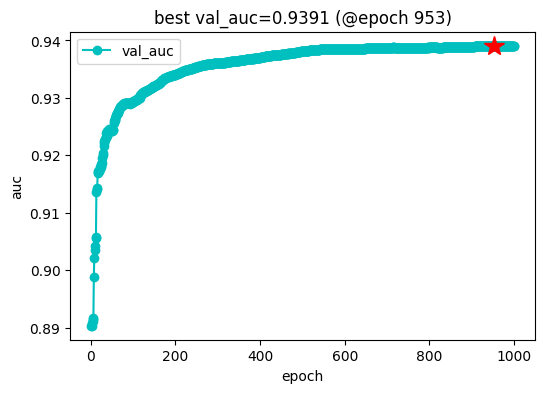

[LightGBM] [Info] Number of positive: 3385, number of negative: 25549
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.821070
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.393268
[LightGBM] [Debug] init for col-wise cost 0.000934 seconds, init for row-wise cost 0.002606 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 981
[LightGBM] [Info] Number of data points in the train set: 28934, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116990 -> initscore=-2.021244
[LightGBM] [Info] Start training from score -2.021244
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
Training until validation scores don't improve for 100 rounds
[LightGBM] [D

,val_auc,epoch
0,0.890328,1
1,0.890328,2
2,0.890765,3
3,0.891202,4
4,0.891463,5
...,...,...
995,0.939025,996
996,0.939024,997
997,0.939027,998
998,0.939029,999


In [8]:
vlog_cb = VLogCallback(params['n_estimators'], monitor_metric = 'val_auc', monitor_mode = 'max')
vlog_cb.vlog.log_start()
result = {}

model = lgb.train(params, ds_train, 
        valid_sets=[ds_val], 
        valid_names=['val'],
        callbacks = [lgb.record_evaluation(result),vlog_cb]
        )

vlog_cb.vlog.log_end()

# 模型评估

In [9]:
from sklearn.metrics import roc_auc_score 
y_pred_val = model.predict(dfval[num_cols+cat_cols], num_iteration=model.best_iteration)
val_auc = roc_auc_score(dfval[target_col],y_pred_val) 

y_pred_test = model.predict(dftest[num_cols+cat_cols], num_iteration=model.best_iteration)
test_auc = roc_auc_score(dftest[target_col],y_pred_test) 

print('val_auc = ',val_auc)
print('test_auc = ' , test_auc)

val_auc =  0.9390840316728618
test_auc =  0.9314767883543457


# 使用模型

In [10]:
#预测概率
y_test = model.predict(dftest[num_cols+cat_cols], num_iteration=model.best_iteration)

#获取样本在每棵树上叶子结点的索引，可以把它们作为onehot特征喂入线性模型
y_test_leaf = model.predict(dftest[num_cols+cat_cols], pred_leaf=True, num_iteration=model.best_iteration)

In [11]:
y_test_leaf

array([[ 5,  5,  4, ..., 25,  5,  2],
       [14, 14, 14, ...,  1, 18,  2],
       [ 5,  5,  4, ...,  1,  3,  2],
       ...,
       [ 5,  5,  4, ...,  1,  0,  2],
       [14, 14, 14, ..., 10,  0,  2],
       [15, 15, 15, ...,  1,  0, 30]], shape=(9043, 953), dtype=int32)

# 保存模型

In [12]:
model.save_model("model.txt")
model_loaded = lgb.Booster(model_file='model.txt')
ypred_test = model_loaded.predict(dftest[num_cols+cat_cols], num_iteration=model_loaded.best_iteration)

[LightGBM] [Debug] Skipped header "tree" in file model.txt
[LightGBM] [Debug] Skipped header "tree" in file model.txt
[LightGBM] [Debug] Time for loading model: 0.013201 seconds
